<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"

# <center>Отчет "Идентификация пользователей по посещенным веб-страницам"

### 1. Цели и задачи проекта

Цель проекта - создание модели, способной проводить идентификацию пользователя, зная последовательность из нескольких посещенных им подряд веб-страниц в интернете.

### 2. Описание исходных и обработанных данных и признаков

В качестве исходных данных использовались записи историй посещения сайтов с прокси-сервера Университета Блеза Паскаля по 150 пользователям.
По каждому пользователю имелась следующая информация:
* Время посещения сайта
* Название посещенного сайта

#### Подгружаем необходимые библиотеки

In [30]:
import os
import pickle
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
from scipy.sparse import csr_matrix, coo_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.linear_model import SGDClassifier, LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_auc_score
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import learning_curve, validation_curve

**Описание исходных данных**

* Признаки site_i – индексы посещенных сайтов.
* Признаки time_j – время посещения сайтов site_j.
* Целевой признак target – факт того, что сессия принадлежит Элис (то есть что именно Элис ходила по всем этим сайтам).

In [2]:
PATH_TO_DATA = 'D:/2017/Coursera/C6/w7/Data_T'

In [3]:
col_names_t = ['time' + str(i) for i in range(1,11)]

In [4]:
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
                       index_col='session_id', parse_dates=col_names_t)
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
                      index_col='session_id', parse_dates=col_names_t)

In [5]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,3846.0,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,39.0,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,782.0,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,178.0,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


In [6]:
train_df.fillna(0, inplace=True)

In [7]:
test_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
1,29,2014-10-04 11:19:53,35.0,2014-10-04 11:19:53,22.0,2014-10-04 11:19:54,321.0,2014-10-04 11:19:54,23.0,2014-10-04 11:19:54,2211.0,2014-10-04 11:19:54,6730.0,2014-10-04 11:19:54,21.0,2014-10-04 11:19:54,44582.0,2014-10-04 11:20:00,15336.0,2014-10-04 11:20:00
2,782,2014-07-03 11:00:28,782.0,2014-07-03 11:00:53,782.0,2014-07-03 11:00:58,782.0,2014-07-03 11:01:06,782.0,2014-07-03 11:01:09,782.0,2014-07-03 11:01:10,782.0,2014-07-03 11:01:23,782.0,2014-07-03 11:01:29,782.0,2014-07-03 11:01:30,782.0,2014-07-03 11:01:53
3,55,2014-12-05 15:55:12,55.0,2014-12-05 15:55:13,55.0,2014-12-05 15:55:14,55.0,2014-12-05 15:56:15,55.0,2014-12-05 15:56:16,55.0,2014-12-05 15:56:17,55.0,2014-12-05 15:56:18,55.0,2014-12-05 15:56:19,1445.0,2014-12-05 15:56:33,1445.0,2014-12-05 15:56:36
4,1023,2014-11-04 10:03:19,1022.0,2014-11-04 10:03:19,50.0,2014-11-04 10:03:20,222.0,2014-11-04 10:03:21,202.0,2014-11-04 10:03:21,3374.0,2014-11-04 10:03:22,50.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:23,3374.0,2014-11-04 10:03:23
5,301,2014-05-16 15:05:31,301.0,2014-05-16 15:05:32,301.0,2014-05-16 15:05:33,66.0,2014-05-16 15:05:39,67.0,2014-05-16 15:05:40,69.0,2014-05-16 15:05:40,70.0,2014-05-16 15:05:40,68.0,2014-05-16 15:05:40,71.0,2014-05-16 15:05:40,167.0,2014-05-16 15:05:44


In [8]:
test_df.fillna(0, inplace=True)

### Первичный визуальный анализ данных

In [9]:
train_df_time = train_df.sort_values('time1')

In [10]:
train_df_time.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,0.0,1970-01-01 00:00:00,0.0,1970-01-01 00:00:00,0.0,1970-01-01 00:00:00,0.0,1970-01-01 00:00:00,0.0,1970-01-01 00:00:00,0.0,1970-01-01 00:00:00,0.0,1970-01-01 00:00:00,0.0,1970-01-01 00:00:00,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,0.0,1970-01-01 00:00:00,0.0,1970-01-01 00:00:00,0.0,1970-01-01 00:00:00,0.0,1970-01-01 00:00:00,0.0,1970-01-01 00:00:00,0.0,1970-01-01 00:00:00,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,945.0,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,946.0,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,952.0,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


In [12]:
df_target = train_df_time[train_df_time['target'] == 1].fillna(0)
df_targer_n = df_target.copy()
df_not_target = train_df_time[train_df_time['target'] == 0].fillna(0)
df_not_targer_n = df_not_target.copy()

In [13]:
df_targer_n['year_month'] = df_targer_n['time1'].apply(lambda x: x.year * 100 + x.month)
df_not_targer_n['year_month'] = df_not_targer_n['time1'].apply(lambda x: x.year * 100 + x.month)
df_test_n = test_df.copy()
df_test_n['year_month'] = df_test_n['time1'].apply(lambda x: x.year * 100 + x.month)

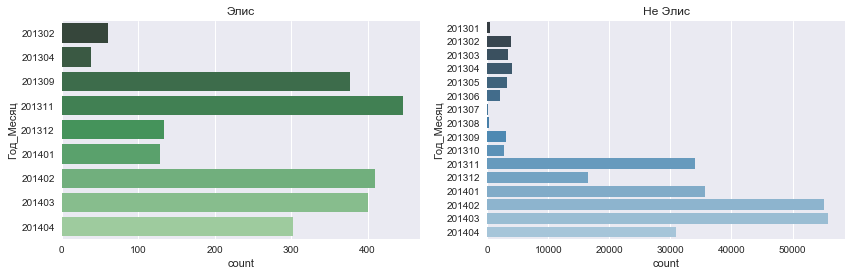

In [14]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

sns.countplot(y = df_targer_n['year_month'], ax=ax1, palette="Greens_d")
ax1.set_title(u'Элис')
ax1.set_ylabel(u'Год_Месяц')

sns.countplot(y = df_not_targer_n['year_month'], ax=ax2, palette="Blues_d")
ax2.set_title(u'Не Элис')
ax2.set_ylabel(u'Год_Месяц')

plt.tight_layout()

In [15]:
for i in range(1, 10):
    train_df['time_diff%d' % i] = (train_df[col_names_t[i]] - train_df[col_names_t[0]]).apply(lambda dt: int(dt.total_seconds()))
    test_df['time_diff%d' % i] = (test_df[col_names_t[i]] - test_df[col_names_t[0]]).apply(lambda dt: int(dt.total_seconds()))

In [16]:
time_diff_cols = ['time_diff%d' % i for i in range(1, 10)]
for col in time_diff_cols:
    train_df[col] = train_df[col].apply(lambda t: 0 if t < 0 else t)
    test_df[col] = test_df[col].apply(lambda t: 0 if t < 0 else t)

In [17]:
train_df[time_diff_cols].head()

,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9
session_id,,,,,,,,,
1,0,0,0,0,0,0,0,0,0
2,0,1,1,1,1,2,2,25,26
3,1,2,2,2,2,3,4,5,7
4,30,60,90,120,150,180,210,240,270
5,137,137,138,138,174,174,174,241,246


**Применим логистическую регрессию**

In [18]:
skf = StratifiedKFold(n_splits=5, random_state=17)

In [19]:
logit = LogisticRegression(random_state=17)

In [20]:
y = train_df['target']

In [21]:
vectorizer = TfidfVectorizer()

In [22]:
col_names_s = ['site' + str(i) for i in range(1,11)]

In [23]:
train_c = []
for x in train_df[col_names_s].itertuples():
    site_ids = [x.site1, x.site2, x.site3, x.site4, x.site5, x.site6, x.site7, x.site8, x.site9, x.site10]    
    train_c.append(' '.join(str(x) for x in site_ids if x != 0))
train_csr = vectorizer.fit_transform(train_c)

In [24]:
test_c = []
for x in test_df[col_names_s].itertuples():
    site_ids = [x.site1, x.site2, x.site3, x.site4, x.site5, x.site6, x.site7, x.site8, x.site9, x.site10]    
    test_c.append(' '.join(str(x) for x in site_ids if x != 0))
test_csr = vectorizer.transform(test_c)

#### Добавляем признаки

In [25]:
train_test_df = pd.concat([train_df, test_df])

In [26]:
def add_fe(func, name_fe):
    train_nf = pd.DataFrame(index=train_df.index)
    test_nf = pd.DataFrame(index=test_df.index)
    train_test_nf = pd.concat([train_nf, test_nf])
    train_test_nf[name_fe] = train_test_df['time1'].apply(func)
    train_test_nf = pd.get_dummies(train_test_nf, columns=[name_fe], sparse=True, drop_first=True)
    train_test_nf.reset_index(inplace=True, drop=True)
    train_nf = train_test_nf[:train_nf.shape[0]]
    test_nf = train_test_nf[train_nf.shape[0]:]
    global train_csr, test_csr
    train_csr = csr_matrix(hstack([train_csr, train_nf.values]))
    test_csr = csr_matrix(hstack([test_csr, test_nf.values]))

In [27]:
add_fe(lambda x: x.month, 'month')
add_fe(lambda x: 100 * x.year + x.month, 'year_month')
add_fe(lambda x: x.dayofweek, 'week_day')
add_fe(lambda x: x.hour, 'hour')

In [28]:
cv_score = cross_val_score(logit, train_csr, y, scoring='roc_auc', cv=skf, n_jobs=-1)
print (np.mean(cv_score))

0.984503926298


In [29]:
train_size = int(.7 * train_csr.shape[0])
X_train, y_train = train_csr[:train_size, :], y[:train_size]
X_valid, y_valid = train_csr[train_size:, :], y[train_size:]
logit.fit(X_train, y_train)
logit_valid_pred_proba = logit.predict_proba(X_valid)
print (roc_auc_score(y_valid, logit_valid_pred_proba[:,1]))

0.983494873285


### Кривые валидации

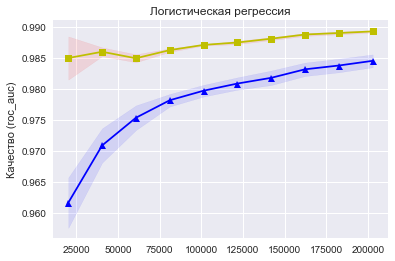

In [42]:
train_s=np.linspace(.1, 1.0, 10)
train_s, train_scores, test_scores = learning_curve(
    logit, train_csr, y, cv=skf, n_jobs=-1, train_sizes=train_s, scoring='roc_auc')
train_sm = np.mean(train_scores, axis=1)
train_ss = np.std(train_scores, axis=1)
test_sm = np.mean(test_scores, axis=1)
test_ss = np.std(test_scores, axis=1)
plt.title(u'Логистическая регрессия')
plt.ylabel(u'Качество (roc_auc)')
plt.legend(loc="best")
plt.fill_between(train_s, train_sm - train_ss, train_sm + train_ss, alpha=0.1, color="r")
plt.fill_between(train_s, test_sm - test_ss, test_sm + test_ss, alpha=0.1, color="b")
plt.plot(train_s, train_sm, 's-', color="y", label=u"Обучающая выборка")
plt.plot(train_s, test_sm, '^-', color="b", label=u"Кросс валидация")

Из графика видно, качество модели растет при увеличение датасета.

#### Submit

In [43]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):   
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [44]:
logit.fit(train_csr, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=17, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [45]:
logit_test_pred_proba = logit.predict_proba(test_csr)

In [46]:
write_to_submission_file(logit_test_pred_proba[:,1], 'D:/2017/Coursera/C6/w7/submit.csv')

### Выводы

Практическое применение построенной модели по идентификации пользователя по его поведению в сети, возможно при решении широкого круга задач. Это могут быть задачи, связанные с обеспечением защиты от несанкционированного доступа к персональным ресурсам: почта, личный кабинет, аккаунт в соцсетях и т.д. 
Также возможность автоматической идентификации пользователя по его поведению возможно для применения в персонализированной рекламе. Подобная система, работающая в интернет браузерах, позволяет идентифицировать пользователя и предложить ему наиболее релевантные объявления, что значительно повышает рентабельность инвестиций, сделанных в рекламу.